# image-classifier

In [1]:
import os
import tensorflow as tf
import abcli
from abcli import *
from abcli import string
from abcli.plugins import gpu
import image_classifier
from image_classifier.model import Image_Classifier

from helper_functions import compare_histories

from abcli import logging
import logging

logger = logging.getLogger(__name__)

logger.info(f"using {abcli.fullname()}, {image_classifier.name}-{image_classifier.version}")
logger.info(f"{os.environ.get('abcli_object_name')} - built on {string.pretty_date()}")

gpu.validate();

using abcli-1.1.477-main, image_classifier-1.1.63
2022-07-06-20-12-58-57931 - built on 07 July 2022, 19:03:25
TensorFlow: 2.6.0
0 GPU(s) available: [].


In [2]:
validation = True
retrain = False

input_object = os.path.join(os.getenv("abcli_object_root"),"ic_input_object_v2")
output_object = os.path.join(os.getenv("abcli_object_root"),"ic_output_object_v1")

initial_epochs = 1 if validation else 5
fine_tune_epochs = 1 if validation else 5

---

In [3]:
if retrain:
    classifier = Image_Classifier(input_object=input_object)
    classifier.fit(
        epochs=initial_epochs,
        input_object=input_object, 
        output_object=output_object,
        train_set="train_30")

---

In [4]:
classifier = Image_Classifier(input_object=input_object)
classifier.load_weights(
    input_object=input_object, 
    output_object=output_object,
    evaluate=False)

2022-07-07 19:03:25.933835: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 15)                19215     
Total params: 4,068,786
Trainable params: 19,215
Non-trainable params: 4,049,571
_________________________________________________________________
None


Found 15000 files belonging to 15 classes.


Pumpkin -model-> Pumpkin (0.22)


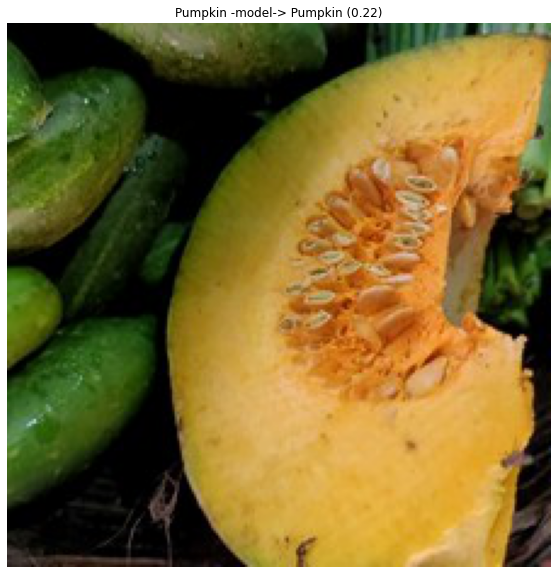

In [5]:
classifier.predict_random_image(input_object=input_object)

---

## Model 2: Fine tuning


### Unfreeze layers

In [ ]:
base_model.trainable = True

# Freeze all layers except the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (We have to recompile our models every time we make a change)
model_2.compile(
  loss='categorical_crossentropy',
  # When fine tuning, you typically want to lower the learning rate by 10X
  optimizer=tf.keras.optimizers.Adam(0.0001),
  metrics=['accuracy']
)

In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

## Fit the model

In [ ]:
fine_tuned_epochs = initial_epochs + fine_tune_epochs

history_2 = model_2.fit(
    test_data,
    epochs=fine_tuned_epochs,
    steps_per_epoch=len(test_data),
    validation_data=validation_data,
    validation_steps = len(validation_data),
    initial_epoch=history_1.epoch[-1]
)

compare_histories(history_1, history_2, initial_epochs)

In [ ]:
model_2_results = model_2.evaluate(test_data)

In [ ]:
model_1_results, model_2_results

* unfreezing some layers gave us a higher percentage although it's already high from model_1

lets try one more time and we'll unfreeze more layers (30)

## Model 3: Unfreeze more layers

In [ ]:
model_3 = tf.keras.Model(inputs, outputs)
model_3.load_weights(checkpoint_path)

In [ ]:
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
  layer.trainable = False


# Recompile (We have to recompile our models every time we make a change)
model_3.compile(
  loss='categorical_crossentropy',
  # When fine tuning, you typically want to lower the learning rate by 10X
  optimizer=tf.keras.optimizers.Adam(0.0001),
  metrics=['accuracy']
)


### Fit the model


In [ ]:
fine_tuned_epochs = initial_epochs + fine_tune_epochs

history_3 = model_3.fit(
    test_data,
    epochs=fine_tuned_epochs,
    steps_per_epoch=len(test_data),
    validation_data=validation_data,
    validation_steps = len(validation_data),
    initial_epoch=history_1.epoch[-1]
)

compare_histories(history_1, history_3, initial_epochs)

In [ ]:
model_3_results = model_3.evaluate(test_data)

# Compare Models

In [ ]:
import pandas as pd
results = [model_1_results , model_2_results, model_3_results]
results_pd = pd.DataFrame(results, columns=['loss', 'accuracy'])
results_pd

# Summary

from the start `EfficientNetB0` gave us a very high score with only 30% of the traning data_augmentation

`model_3` gives us the best accuracy score with 30 layers of the base model unfrozen and re-fitted on our custom data

In [ ]:
model_3.summary()

In [ ]:
# END